<a href="https://colab.research.google.com/github/RyanBurnell/Object-permanence-inference-model/blob/main/ObjectPermanenceTaskStructure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymc
!pip install numpy
!pip install arviz
!pip install erroranalysis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pymc as pm
import numpy as np
import arviz as az
import random as rm
from scipy import stats
import pandas as pd
import erroranalysis as ea
import matplotlib.pyplot as plt


print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.1.4


In [ ]:
agentCols=[]

In [ ]:
######### Generate simulated data if needed or read in file #########
# Reading the dataset from the file. ****NEED TO UPLOAD THE DATA INTO COLAB EACH TIME. IT WILL GET DELETED AFTER EACH SESSION IS TERMINATED****
df = pd.read_csv ('AgentsWithMetaData.csv')#pd.read_csv ('AgentsWithMetaData.csv')

useDummyData = True # We have real data so not needed

#Create a fake dataset with appropriate column names for usage later

if useDummyData:
  # Creating some agents to see if we can recover the right values of the abilities

  length = df["InstanceName"].count()
  #df.append()

  randomAgent = np.random.uniform(0,1,length).round()
  df['perfectAgent'] = [1]*length
  df['worstAgent'] = [0]*length
  df['perfectAgentWhenNoLava'] = 1 - df["LavaPresence"]
  df['perfectAgentTimeBelowThree'] = (df["TimeUnderOcclusion"] < 3) * 1.0  # Ignoring everything else as being solved by the agent the ability would be at least 11 * 2.5 = 27.5
  df['perfectAgentTimeBelowTwo'] = (df["TimeUnderOcclusion"] < 2) * 1.0  # Ignoring everything else as being solved by the agent the ability would be at least 11 * 1.5 = 16.5
  df['perfectAgentPositionsBelowTen'] = (df["TimeUnderOcclusion"] * df["NumOtherPositionsAvailable"] < 10) * 1.0  # Ignoring everything else as being solved by the agent the ability would be exactly 10
  df['AgentNoObjPerm'] = (df["TimeUnderOcclusion"] * df["NumOtherPositionsAvailable"] == 0.0) * 1.0  # Ignoring everything else as being solved by the agent the ability would be exactly 0
  df['AgentNoObjPermOrLava'] = (df["TimeUnderOcclusion"] + df["LavaPresence"] == 0) * 1.0
  df['AgentNoObjPermOrRamp'] = (df["TimeUnderOcclusion"] + df["RampPresence"] == 0) * 1.0
  agentCols = df.columns[df.columns.str.contains(r'\D*Agent[^0-9]*$')] ## Doesn't include the ones with numbers at the end from the table.
  print(agentCols)
  # All of them work and the abilities are recovered almost perfectly
  #taskResults = perfectAgent
  #taskResults = perfectAgentWhenNoLava
  #taskResults = perfectAgentWhenTimeOccludedLowerThan3  # This is the only for which the initialisation of the model worked with John's framework, provided only the first 50 examples are given
  #taskResults = perfectAgentWhenTimeOccludedLowerThan2 
  #taskResults = perfectAgentWhenTimexPositionsLowerThan10
  #taskResults = perfectAgentWithNoObjectPermanence
  #taskResults = worstAgent
  #taskResults = [0,1]
else: 
  #Create list of agents included in the data. Assumes naming convention Agent1, Agent2, etc.
  agentCols = df.columns[df.columns.str.contains('Agent')]
  print(agentCols)
  ### Make a separate df for the agent data [not needed]
  #agents = df[agentCols]
  #agents['InstanceName'] = df['InstanceName']

  #print(df.head())
  #print(agents.head())
  #df.describe()


Index(['perfectAgent', 'worstAgent', 'perfectAgentWhenNoLava',
       'perfectAgentTimeBelowThree', 'perfectAgentTimeBelowTwo',
       'perfectAgentPositionsBelowTen', 'AgentNoObjPerm',
       'AgentNoObjPermOrLava', 'AgentNoObjPermOrRamp'],
      dtype='object')


In [ ]:
####Clean up feature data columns#######

df['OccluderPresence']= (df['TimeUnderOcclusion'] != 0) * 1.0   # Creating new variable for OccluderPresence
df['NumOtherPositionsAvailable'] = df['NumOtherPositionsAvailable'].fillna(0)  # Replace nans by 0s
df['GoalSize']=df['GoalSize'].astype(np.double)
df["OccluderRedness"]=df["OccluderRedness"].fillna(0)
df["OccluderGreenness"]=df["OccluderGreenness"].fillna(0)
df["OccluderBlueness"]=df["OccluderBlueness"].fillna(0)
#Print unique values for key features
print('TimeUnderOcclusion: ',df['TimeUnderOcclusion'].unique())
print('RightLeftPosition: ',df['RightLeftPosition'].unique())
print('NumOtherPositionsAvailable: ',df['NumOtherPositionsAvailable'].unique())
print('Goal sizes: ',df['GoalSize'].unique())   
print('Occluder Colours: ',df['OccluderColour'].unique())  # Still need to have an extra arrow to occluder for nans

#Print head of dataframe
print(df.head())
#df.describe()
#df.count()

TimeUnderOcclusion:  [3 1 2 4 0]
RightLeftPosition:  [-1  1  0]
NumOtherPositionsAvailable:  [ 1.  2.  3.  7. 11.  0.]
Goal sizes:  [2.  0.5 1.  2.5 3.  1.5 4.  5. ]
Occluder Colours:  ['Beige' 'Brown' 'DarkBlue' 'DarkGreen' 'Grey' 'OffWhite' 'Blue' nan]
  Paradigm                                       InstanceName  \
0  CVChick  OP-STC-Allo-CVChick-1Occluder-Left-Beige-0-OPQ...   
1  CVChick  OP-STC-Allo-CVChick-1Occluder-Left-Brown-0-OPQ...   
2  CVChick  OP-STC-Allo-CVChick-1Occluder-Left-DarkBlue-0-...   
3  CVChick  OP-STC-Allo-CVChick-1Occluder-Left-DarkGreen-0...   
4  CVChick  OP-STC-Allo-CVChick-1Occluder-Left-Grey-0-OPQ.yml   

      AbilityTested  LavaPresence  PlatformPresence  RampPresence  \
0  ObjectPermanence             1                 1             0   
1  ObjectPermanence             1                 1             0   
2  ObjectPermanence             1                 1             0   
3  ObjectPermanence             1                 1             0   
4  Object

In [ ]:
###Some data exploration###
#TODO - erroranalysis.ai?? Port over IJCAI code??

#FOR EACH AGENT, look at patterns of performance

# Checking some biases:
#print(np.corrcoef(taskResults, df["RightLeftPosition"])[0,1]) 
#print(np.corrcoef(taskResults, df["OccluderRedness"])[0,1]) 
#print(np.corrcoef(taskResults, df["OccluderGreenness"])[0,1]) 
#print(np.corrcoef(taskResults, df["OccluderBlueness"])[0,1])   # There's some correlation with the blue (this will be seen in the results)


In [ ]:
# Performances are always observable, and in this case between 0 and 1. They are events, and their unit is happening/not happening.
# Features are also observable, and can have different scales (0/1, lavaPresence, or 1..10, numPositions, etc). They have units.
# Abilities have the scale that derives from the operations that are performed on the features, and have the units derived from it. Usually binary when the attribute is binary, and in other ranges in other cases.
# Margins are comparisons between abilities and features, usually expressed in terms of probabilities (PrMargin), or in terms of logodds (LOMargin). They have the same unit as the ability.
# "P"s is what we previously called "latent performances", but this name is a bit of an aberration, even if thought as an imaginary performance if the diagram stopped there. I just call them P for the moment because they are probabilities.
# Weights (W) are random variables that have to be estimated to see how each component affects performance


In [ ]:
######Define values & functions that will be used to define the model later########
uniformAbilitySlack = 1.1 # Constant to multiply the maximum of abilities that are uniform to allow for the value to be above the maximum observable value for the corresponding feature

#Decide "maximum capabilities" based on the hardest values in the dataset
maxTime = max(df["TimeUnderOcclusion"])
print('maxTime: ', maxTime)
maxPositions = max(df["NumOtherPositionsAvailable"])
print('maxPositions: ',maxPositions)
maxGoalSize= max(df["GoalSize"])
print('maxGoalSize: ', maxGoalSize) 
maxPermAbility = maxTime* maxPositions* uniformAbilitySlack      
print('maxPermAbility: ', maxPermAbility)   
maxMemoryAbility = maxTime * uniformAbilitySlack            
print('maxMemoryAbility: ', maxMemoryAbility)   

#Define useful functions for use within the model
def logistic(x):
  return 1 / (1 + np.exp(-x))

def SimplePrMargin(ability, binaryFeature): # must return a value between 0 and 1
  return 1-((1-ability)*binaryFeature)  # If binaryFeature is 0 then the margin represents p(success)=1. If binaryFeature = 1 then p(success)=ability

# updated to set margin as max when no occluder is present
def objPermanenceLOMargin(ability, occluderPresence, timeUnderOcclusion, numPositions): #,  visualAcuityP): # must return a value between -inf and inf (more precisely between -maxPermAbility and maxPermAbility)
  OPPerformance = ability  - timeUnderOcclusion * numPositions
  return maxPermAbility-((maxPermAbility-OPPerformance)*occluderPresence)
  #return ability  - occluderPresence * timeUnderOcc * numPositions  # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success
  #  return ability - timeUnderOcc * maxPositions - numPositions * maxTime  # Keeping same ranges but making it additive and possibly easier
  # It's probably better to use some weighted generalised mean, but for the moment the product makes more sense

def visualAcuityLOMargin(ability, goalSmallness): # must return a value between -inf and inf  (more precisely between -maxVisualAcuityAbility and maxVisualAcuityAbility)
  return ability - goalSmallness   # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success

def memoryLOMargin(ability, timeUnderOcc): # must return a value between -inf and inf  (more precisely between -maxMemoryAbility and maxMemoryAbility)
  return ability - timeUnderOcc   # Goes between -inf to inf, with logodds=0 meaning this would lead to 0.5 chance of success

def navigationPrMargin(simpleNavigationP, lavaP, rampP, platP) :  # , visualAcuityP): # must return a value between 0 and 1
  #   return (simpleNavigationP + lavaP + rampP + platP) / 4  # This is the only case where an ability goes directly to a performance, without any feature of the instance intermediating. Perhaps if we had distance...
                                                            # By dividing by four, we keep the range 0..1
  return simpleNavigationP * lavaP * rampP * platP # * visualAcuityP  # I think a product makes more sense, since if lavaPerf is zero, this means there's lava and the ability of handling lava is zero, with a high probability of failure.
  # It's probably better to use some weighted generalised mean, but for the moment the product makes more sense

def finalTaskPrMargin(objPermanenceP, navigationP, visualAcuityP): # must return a value between 0 and 1
  #  return (objPermanenceP + navigationP)/2  
  return objPermanenceP * navigationP * visualAcuityP       # Again I consider that we need both things if we do have both things.  

abilityMin = {} #Initialize ability Min and max dataframes for plotting ranges
abilityMax = {}

maxTime:  4
maxPositions:  11.0
maxGoalSize:  5.0
maxPermAbility:  48.400000000000006
maxMemoryAbility:  4.4


In [ ]:
###### Define function that generates a PyMC model following our theorised structure. This will be called once for each agent.
includeIrrelevantFeatures = True
memoryEffect = "directIndirect" # "none" if ignoring memory entirely # "directIndirect" if memory goes to both performance and OP ability
def SetupModel(taskResults):
  m = pm.Model()
  with m:
    
    ## Define priors (about the agent)
    #memory & OP abilities
    if memoryEffect == "none":
      # objPermAbility = pm.Exponential("objPermAbility", 1)             # [0,inf] Exponential distribution with lambda around 1 (this one gives problems)
      # objPermAbility = pm.Normal("objPermAbility", 30, 20)              # Note that time goes between 0 and 4 and positions quite high (11) so this number can be  40. The value has to be close and the sigma high otherwise the initialisation fails
      # objPermAbility = pm.TruncatedNormal("objPermAbility", mu=30, sigma=10, lower=0) # [0,inf] This one makes more sense than the normal, but it gives error even with high sigma
      # objPermAbility = maxPermAbility* pm.Beta("objPermAbility", 1, 1)  # [0,maxPermAbility] This is the one that works best
      objPermAbility = pm.Uniform("objPermAbility", 0, maxPermAbility)  # [0,maxPermAbility] This is the same as above, but we have the ability in the right magnitude
      abilityMin["objPermAbility"] = 0
      abilityMax["objPermAbility"] = maxPermAbility
    elif memoryEffect == "directOnly":
      memoryAbility = pm.Uniform("memoryAbility", 0, maxMemoryAbility)  # [0,maxMemoryAbility] This is the same as above, but we have the ability in the right magnitude
      abilityMin["memoryAbility"] = 0
      abilityMax["memoryAbility"] = maxMemoryAbility
      
      objPermAbility = pm.Uniform("objPermAbility", 0, maxPermAbility)  # [0,maxPermAbility] This is the same as above, but we have the ability in the right magnitude
      abilityMin["objPermAbility"] = 0
      abilityMax["objPermAbility"] = maxPermAbility
    elif memoryEffect == "directIndirect":
      memoryAbility = pm.Uniform("memoryAbility", 0, maxMemoryAbility)  # [0,maxMemoryAbility] This is the same as above, but we have the ability in the right magnitude
      abilityMin["memoryAbility"] = 0
      abilityMax["memoryAbility"] = maxMemoryAbility
      
      objPermAbility = pm.Uniform("objPermAbility", 0, memoryAbility * maxPositions )  # [0,maxPermAbility]  # This introduces memoryAbility in a product, so mostly non-compensatory and as a cap.
      abilityMin["objPermAbility"] = 0
      abilityMax["objPermAbility"] = maxMemoryAbility * maxPositions

    #Visual acuity
    maxVisualAcuityAbility = maxGoalSize* uniformAbilitySlack                       # The 1.1 is to have some margin to see also if it overestimates in those cases where this ability is maximal
    visualAcuityAbility = pm.Uniform("visualAcuityAbility", 0, maxVisualAcuityAbility)
    abilityMin["visualAcuityAbility"] = 0
    abilityMax["visualAcuityAbility"] = maxVisualAcuityAbility
    
    # flatNavAbility = pm.Beta("flatNavAbility", 1,1)                  # [0,1] This is just moving around without lava, platforms or ramps. For consistency with other simple tasks (and IJCAI paper) this should be [0,inf] and depend on size and location of goal 
    flatNavAbility = pm.Normal("flatNavAbility", 0, 1)                 # [-inf,inf] This is an ability centered on 0, as it is used directly as a logit joinlty with the Left/Right influence
    abilityMin["flatNavAbility"] = -np.inf
    abilityMax["flatNavAbility"] = np.inf
    lavaAbility = pm.Beta("lavaAbility", 1,1)                        # [0,1] Specific ability with lava
    abilityMin["lavaAbility"] = 0
    abilityMax["lavaAbility"] = 1
    #  lavaAbility = pm.Deterministic("lavaAbility", pm.math.constant(0.5))
    platformAbility = pm.Beta("platformAbility",1,1)                  # [0,1] Specific ability with platforms
    abilityMin["platformAbility"] = 0
    abilityMax["platformAbility"] = 1
    #  platformAbility = pm.Deterministic("platformAbility", pm.math.constant(0.5))       
    rampAbility = pm.Beta("rampAbility",1,1)                          # [0,1] Specific ability with ramps
    abilityMin["rampAbility"] = 0
    abilityMax["rampAbility"] = 1
    #  rampAbility = pm.Deterministic("rampAbility", pm.math.constant(0.5))                         
    
    # Other properties of the agent that we wouldn't call abilities, we can call them "bias"
    
    if (includeIrrelevantFeatures) :
      rightLeftBias = pm.Normal("rightLeftBias", 0,1)                  # [-inf,inf] A parameter to determine whether left or right have an influence. It's expected to be zero, but negative would be left influence and positive a right influence (or vice versa :-) 
      abilityMin["rightLeftBias"] = -np.inf
      abilityMax["rightLeftBias"] = np.inf
      rednessBias = pm.Normal("rednessBias", 0,1)                      # [-inf,inf] A parameter to determine whether redness has an influence
      abilityMin["rednessBias"] = -np.inf
      abilityMax["rednessBias"] = np.inf
      greennessBias = pm.Normal("greennessBias", 0,1)                  # [-inf,inf] A parameter to determine whether greenness has an influence
      abilityMin["greennessBias"] = -np.inf
      abilityMax["greennessBias"] = np.inf
      bluenessBias = pm.Normal("bluenessBias", 0,1)                    # [-inf,inf] A parameter to determine whether blueness has an influence  
      abilityMin["bluenessBias"] = -np.inf
      abilityMax["bluenessBias"] = np.inf

    ## Environment variables as Deterministic (about the instance)
    ## RELEVANT
    lavaPresence = pm.Deterministic("lavaPresence", pm.math.constant(df["LavaPresence"].values))
    rampPresence = pm.Deterministic("rampPresence", pm.math.constant(df["RampPresence"].values))
    platformPresence = pm.Deterministic("platformPresence", pm.math.constant(df["PlatformPresence"].values))
    timeUnderOcc = pm.Deterministic("timeUnderOcc", pm.math.constant(df["TimeUnderOcclusion"].values))
    numPositions = pm.Deterministic("numPositions", pm.math.constant(df["NumOtherPositionsAvailable"].values))
    occluderPresence = pm.Deterministic("occluderPresence", pm.math.constant(df["OccluderPresence"].values))
    goalSize = pm.Deterministic("goalSize", pm.math.constant(df["GoalSize"].values))
    # Not considered yet  
    # "GoalSize" -> Affects visual acuity. This should influence simpleNavigationP as well?
    # "TransparentWallPresence"
    # "LightsOutPresence"
    # "GoodGoalBounce?"
    # "ForcedChoice?"
    #
    ## SUPPOSEDLY IRRELEVANT
    if (includeIrrelevantFeatures) :
      rightLeftPosition = pm.Deterministic("rightLeftPosition", pm.math.constant(df["RightLeftPosition"].values))
      occluderRedness = pm.Deterministic("occluderRedness", pm.math.constant(df["OccluderRedness"].values))
      occluderGreenness = pm.Deterministic("occluderGreenness", pm.math.constant(df["OccluderGreenness"].values))
      occluderBlueness = pm.Deterministic("occluderBlueness", pm.math.constant(df["OccluderBlueness"].values))
    # "RowPosition"
    # "ColumnPosition"

    goalSmallness = maxGoalSize - goalSize
    visualAcuityP = pm.Deterministic("visualAcuityP", logistic(visualAcuityLOMargin(visualAcuityAbility, goalSmallness)))

    if (includeIrrelevantFeatures) :
      rightLeftEffect = pm.Deterministic("rightLeftEffect", rightLeftBias * rightLeftPosition) 
    else :
      rightLeftEffect = 0
      
    ## Performance metrics based on Navigation and hazards
    # Simple navigation including one supposed irrelevant feature
    # flatNavP = pm.Bernoulli("flatNavP", logit_p = flatNavAbility + rightLeftBias * rightLeftPosition) 
    flatNavP = pm.Deterministic("flatNavP", logistic(flatNavAbility + rightLeftEffect))

    # Other relevant features for non-flat navigation (climbing and jumping)
    #lavaP = pm.Bernoulli("lavaP", SimplePrMargin(lavaAbility, lavaPresence)) ## If LavaPresence is 0 then lavaPerformance has p(success)=1. If LavaPresence = 1 then p(success)=lavaAbility
    lavaP = pm.Deterministic("lavaP", SimplePrMargin(lavaAbility, lavaPresence))
    #rampP = pm.Bernoulli("rampP", SimplePrMargin(rampAbility, rampPresence)) 
    rampP = pm.Deterministic("rampP", SimplePrMargin(rampAbility, rampPresence)) 
    #  rampP = 1.0
    # platformP = pm.Bernoulli("platformP", SimplePrMargin(platformAbility, platformPresence))
    platformP = pm.Deterministic("platformP", SimplePrMargin(platformAbility, platformPresence))
  #  platformP = 1.0
    # navP = pm.Bernoulli("NavP", navigationPrMargin(flatNavP, lavaP, rampP, platformP)) 
    navP = pm.Deterministic("navP", navigationPrMargin(flatNavP, lavaP, rampP, platformP)) #, visualAcuityP)) 
    #navP = pm.Deterministic("NavP", pm.math.constant(0.5))

    # Occluder Colour Bias
    if (includeIrrelevantFeatures) :
      # occluderRedness Goes between 0 and 255, we need to divide by 255 to get it between 0 and 1, and then put it between -1 and 1 as doen for all biases
      occluderRednessSign = occluderRedness / 255.0 * 2.0 - 2.0  
      occluderGreennessSign = occluderGreenness / 255.0 * 2.0 - 2.0  
      occluderBluenessSign = occluderBlueness / 255.0 * 2.0 - 2.0  
      occluderColourEffect = pm.Deterministic("occluderColourBias", (rednessBias * occluderRednessSign + greennessBias * occluderGreennessSign + bluenessBias * occluderBluenessSign) * occluderPresence)  # If occluder is not present there should not be any effect  
    else :
      occluderColourEffect = 0  # To ignore the effect of colour in the model

    if memoryEffect == "none":
      #OP performance determined by OP ability plus occluder presence, time under occlusion and numpositions. Memory considered part of OP
      OPLOM = objPermanenceLOMargin(objPermAbility, occluderPresence, timeUnderOcc, numPositions) # , visualAcuityP)
      logisticOPLOM = logistic(OPLOM + occluderColourEffect)
      objPermP = pm.Deterministic("objPermP", logistic(OPLOM + occluderColourEffect))
    else:
      MEMM = memoryLOMargin(memoryAbility, timeUnderOcc)
      memoryP = pm.Deterministic("memoryP", logistic(MEMM))  
      if memoryEffect == "directIndirect":
        #OP performance determined by memory ability, max time and number of positions - but if no occluder, OP performance should be at maximum. Memory considered to feed into OP and OP performance
        OPLOM = objPermanenceLOMargin(objPermAbility, occluderPresence, maxTime, numPositions) # , visualAcuityP)  # We set timeUnderOcc=maxTime because this has been considered already by memoryP, which will be used later on
        objPermP = pm.Deterministic("objPermP", memoryP * logistic(OPLOM + occluderColourEffect))      
      elif memoryEffect == "directOnly":
        #OP performance determined by OP ability plus numpositions. Memory considered separate to OP               
        OPLOM = objPermanenceLOMargin(objPermAbility, occluderPresence, maxTime, numPositions) # , visualAcuityP)  # We set timeUnderOcc=maxTime because this has been considered already by memoryP, which will be used later on
        objPermP = pm.Deterministic("objPermP", memoryP * logistic(OPLOM + occluderColourEffect))
          
    # Beta distributions can also be specified with mean, mean (0 < mu < 1) and  standard deviation (1 < sigma < sqrt(mu * (1 - mu))). And this way we can introduce a prior.  
    # memoryAbilityPriorMean01 = memoryAbility/maxMemoryAbility # MemoryAbility prior between 0 and 1
    # mu = memoryAbilityPriorMean01
    # memoryAbilityPriorSDev01 = (1 + np.sqrt(mu*(1-mu)))/2.0  # The prior for the SD is the mean of the minimum and maximum possible SDs
    # objPermAbility = maxPermAbility * pm.Beta("objPermAbility", memoryAbilityPriorMean01, memoryAbilityPriorSDev01 )  # [0,maxPermAbility] 


    taskPerformance = pm.Bernoulli("taskPerformance", finalTaskPrMargin(objPermP, navP, visualAcuityP), observed=taskResults)  
    #data = pm.sample(5000)
    #priorData=pm.sample_prior_predictive(5000)

  pm.model_graph.model_to_graphviz(m)

  return m

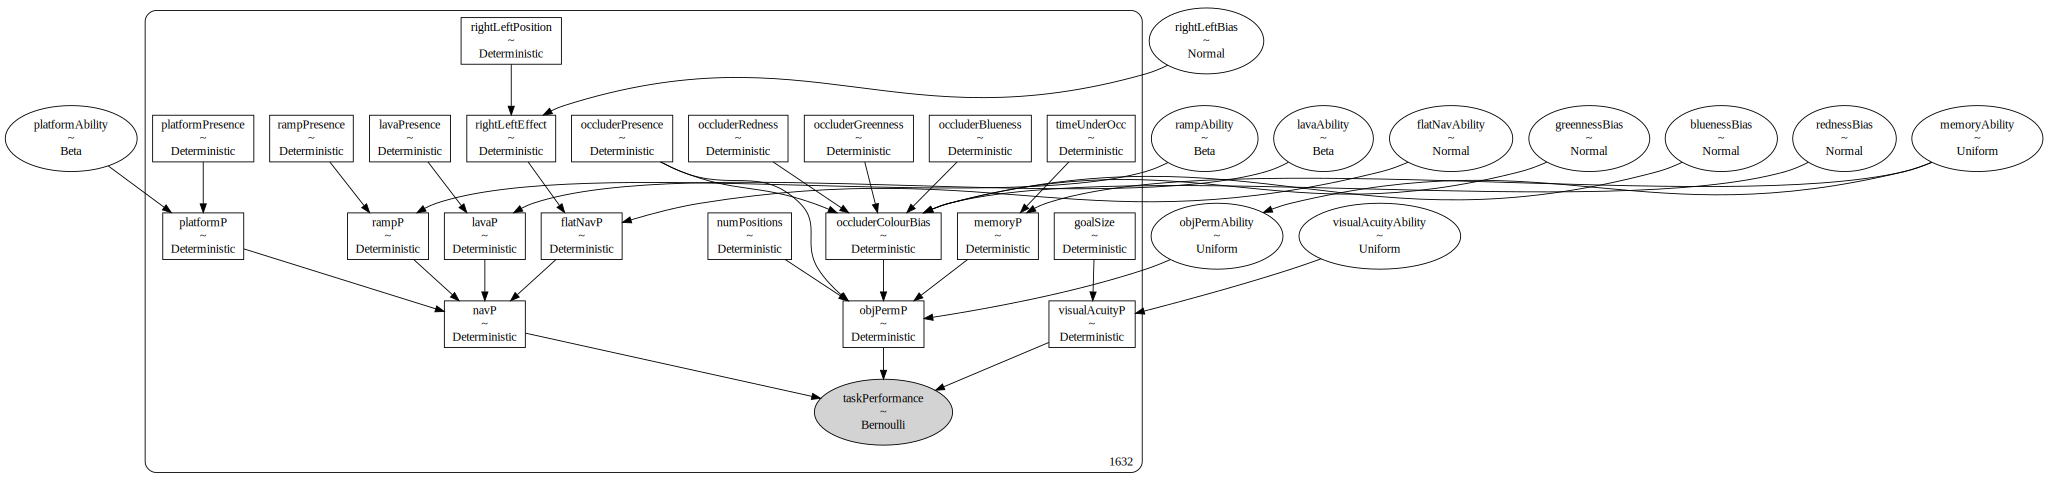

In [ ]:
from IPython.display import Image
import graphviz  
taskResults = df["Agent1"] #set task results with first agent just to generate the model diagram
m = SetupModel(taskResults)
gv = pm.model_graph.model_to_graphviz(m)
gv.format="png"
gv.render
gv.render(directory='viz')
Image("viz/Digraph.gv.png")
gv
## We can make viz less bad

In [ ]:
print(len)

<built-in function len>


In [ ]:
##### Sample results for each agent using the model defined in the function above.
allAgentData = [] #blank list for entering the outputs of the pm sampling for each agent
agentNames = [] #blank list for the agent names
agentColList = agentCols.tolist()
print(agentColList)
numAgents = len(agentColList) #Number of agents, replace with a small number for testing to save time
print(numAgents)
for i in range(numAgents): # Iterate through each agent. 
  agent = agentCols[i] #Get the agent name
  taskResults = df[agent] #Grab the column of results for that agent
  print(agent) 
  print(np.mean(taskResults)) #print mean performance for the agent across all tasks
  m = SetupModel(taskResults) #Define the model using the setupModel function. Needs to be redefined each run after taskResults are updated or PyMC won't use the latest taskResults
  
  #Now sample based on this agent's performance
  with m: 
    agentData = pm.sample(1000) #Might need more samples to converge
  
  #Now add results to lists
  agentNames.append(agent)
  allAgentData.append(agentData)
  
#now combine names and data into one dataframe
fullData = pd.DataFrame(
    {'agentName': agentNames,
     'agentData': allAgentData,
    })

print(fullData)


['perfectAgent', 'worstAgent', 'perfectAgentWhenNoLava', 'perfectAgentTimeBelowThree', 'perfectAgentTimeBelowTwo', 'perfectAgentPositionsBelowTen', 'AgentNoObjPerm', 'AgentNoObjPermOrLava', 'AgentNoObjPermOrRamp']
9
perfectAgent
1.0


ERROR:pymc:There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


worstAgent
0.0


perfectAgentWhenNoLava
0.7279411764705882


ERROR:pymc:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


perfectAgentTimeBelowThree
0.8088235294117647


ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


perfectAgentTimeBelowTwo
0.7696078431372549


perfectAgentPositionsBelowTen
0.2769607843137255


AgentNoObjPerm
0.0


AgentNoObjPermOrLava
0.5


ERROR:pymc:There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


AgentNoObjPermOrRamp
0.6397058823529411


ERROR:pymc:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


                       agentName  \
0                   perfectAgent   
1                     worstAgent   
2         perfectAgentWhenNoLava   
3     perfectAgentTimeBelowThree   
4       perfectAgentTimeBelowTwo   
5  perfectAgentPositionsBelowTen   
6                 AgentNoObjPerm   
7           AgentNoObjPermOrLava   
8           AgentNoObjPermOrRamp   

                                           agentData  
0  (posterior, log_likelihood, sample_stats, obse...  
1  (posterior, log_likelihood, sample_stats, obse...  
2  (posterior, log_likelihood, sample_stats, obse...  
3  (posterior, log_likelihood, sample_stats, obse...  
4  (posterior, log_likelihood, sample_stats, obse...  
5  (posterior, log_likelihood, sample_stats, obse...  
6  (posterior, log_likelihood, sample_stats, obse...  
7  (posterior, log_likelihood, sample_stats, obse...  
8  (posterior, log_likelihood, sample_stats, obse...  


In [ ]:
######## Plot and output results of the analysis #########

#az.plot_dist(data['posterior'].to_array(), label="Posterior")   # With so many variables this requires a lot of memory
# Plotted together they overlap, better one by one
#az.plot_trace(data, combined=True, var_names=["objPermAbility", memoryAbility, "flatNavAbility", "lavaAbility", "platformAbility", "rampAbility", "rightLeftBias"]);
from google.colab import data_table
from vega_datasets import data

data_table.enable_dataframe_formatter()
#Define which abilities we want to plot
abilitiesToShow = ["objPermAbility", "flatNavAbility", "visualAcuityAbility","lavaAbility", "platformAbility", "rampAbility"]
if memoryEffect != "none":
    abilitiesToShow.append("memoryAbility")
if (includeIrrelevantFeatures) :
  abilitiesToShow = abilitiesToShow + ["rightLeftBias", "rednessBias", "greennessBias", "bluenessBias"]

abilityDF = pd.DataFrame( {'Ability': abilitiesToShow}) #Set up dataframe to store ability estimates for all agents
OPDF = []
#Now iterate through each agent and plot the results. Also add the posterior mean estimates for each ability to a dataframe for an overall view
for i in range(fullData.shape[0]): # iterate through each agent
  agentName = fullData.loc[i].at["agentName"] #extract agent name
  print(agentName)
  data = fullData.loc[i].at["agentData"] #Pull out the model outputs for the current agent
  OPDF.append(np.mean(data['posterior']["objPermP"]))
  abilityMeans = [] # empty list to add in ability means to
  abilitySDs = []
  for a in abilitiesToShow: #iterate through each ability, add posterior mean to dataframe, and plot posterior
    #print('Plotting ',a)
    posteriorMean = float(np.mean(data['posterior'][a])) # calculate posterior mean
    posteriorSD = float(np.std(data['posterior'][a])) #calculate posterior sd
    abilityMeans.append(str(round(posteriorMean,2))+" ") # add ability mean estimate to list for this agent
    abilitySDs.append("     "+str(round(posteriorSD,2)))
    #print(a, ", range: [", round(abilityMin[a],1), ":", round(abilityMax[a],1), "]")
    #print("Posterior distribution, m = ", posteriorMean, ", sd = ", posteriorSD) #print posterior for this ability


    #print(data['posterior'][a].shape)
    #print(data['posterior'][a].head())
    #plt.hist(data['posterior'][a])
    #az.plot_trace(data.posterior, combined=True, var_names=[a]); #plot posterior for this ability
 #   print("----------------------------")
  #abilityDF
  abilityDF[agentName] = list(zip(abilityMeans, abilitySDs)) #now append the posterior means for this agent to the dataframe

abilityDF # Now print ability estimates for all agents

perfectAgent
worstAgent
perfectAgentWhenNoLava
perfectAgentTimeBelowThree
perfectAgentTimeBelowTwo
perfectAgentPositionsBelowTen
AgentNoObjPerm
AgentNoObjPermOrLava
AgentNoObjPermOrRamp


,Ability,perfectAgent,worstAgent,perfectAgentWhenNoLava,perfectAgentTimeBelowThree,perfectAgentTimeBelowTwo,perfectAgentPositionsBelowTen,AgentNoObjPerm,AgentNoObjPermOrLava,AgentNoObjPermOrRamp
0,objPermAbility,"(46.37 , 1.56)","(6.39 , 8.14)","(46.41 , 1.56)","(32.6 , 1.08)","(33.47 , 1.33)","(33.06 , 4.88)","(6.82 , 8.73)","(3.64 , 6.92)","(1.38 , 1.14)"
1,flatNavAbility,"(5.79 , 0.4)","(-3.26 , 0.61)","(5.52 , 0.41)","(5.45 , 0.39)","(5.42 , 0.42)","(-0.63 , 0.07)","(-3.28 , 0.64)","(5.2 , 0.41)","(5.4 , 0.4)"
2,visualAcuityAbility,"(5.5 , 0.0)","(0.44 , 0.49)","(5.49 , 0.01)","(5.49 , 0.01)","(5.49 , 0.01)","(5.29 , 0.16)","(0.45 , 0.53)","(5.49 , 0.01)","(5.49 , 0.01)"
3,lavaAbility,"(1.0 , 0.0)","(0.42 , 0.28)","(0.0 , 0.0)","(1.0 , 0.0)","(1.0 , 0.0)","(0.99 , 0.01)","(0.41 , 0.29)","(0.01 , 0.0)","(1.0 , 0.0)"
4,platformAbility,"(1.0 , 0.0)","(0.5 , 0.29)","(0.99 , 0.01)","(0.96 , 0.04)","(0.33 , 0.05)","(0.99 , 0.01)","(0.5 , 0.3)","(0.51 , 0.29)","(0.39 , 0.29)"
5,rampAbility,"(1.0 , 0.0)","(0.49 , 0.29)","(1.0 , 0.0)","(0.99 , 0.01)","(0.98 , 0.02)","(1.0 , 0.0)","(0.49 , 0.29)","(0.4 , 0.3)","(0.46 , 0.29)"
6,memoryAbility,"(4.39 , 0.01)","(1.23 , 1.2)","(4.39 , 0.01)","(3.02 , 0.09)","(3.11 , 0.11)","(4.38 , 0.02)","(1.27 , 1.2)","(4.31 , 0.08)","(4.33 , 0.07)"
7,rightLeftBias,"(0.0 , 0.51)","(0.0 , 0.64)","(0.0 , 0.49)","(-0.0 , 0.55)","(-0.01 , 0.54)","(-0.0 , 0.08)","(0.0 , 0.62)","(-0.01 , 0.52)","(-0.0 , 0.54)"
8,rednessBias,"(-0.8 , 0.85)","(0.03 , 1.02)","(-0.86 , 0.88)","(-3.41 , 0.79)","(-2.81 , 0.81)","(-0.02 , 0.98)","(-0.0 , 1.02)","(0.25 , 0.92)","(0.41 , 0.92)"
9,greennessBias,"(-0.84 , 0.84)","(0.01 , 1.04)","(-0.84 , 0.86)","(-3.4 , 0.78)","(-2.82 , 0.81)","(-0.01 , 0.99)","(0.01 , 1.04)","(0.25 , 0.99)","(0.4 , 0.92)"


|index|Ability|Agent1|Agent2|Agent3|Agent4|Agent5|Agent6|Agent7|Agent8|Agent9|Agent10|Agent11|Agent12|Agent13|Agent14|Agent15|Agent16|Agent17|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|0|objPermAbility|47\.02003323372466|46\.098626776216534|45\.05132189033916|46\.92419295994417|46\.95938413795061|46\.96565813027254|46\.958537707997316|45\.55983018633011|46\.977144269883325|46\.06943086068638|46\.70518019956784|46\.72152326213992|46\.863015802808555|47\.02644400875298|46\.94022802900066|35\.05926021063485|43\.63009523498952|
|1|flatNavAbility|5\.795104928150736|0\.47984809254763205|-0\.829744125864359|3\.969226688564791|4\.778852333108284|4\.836020901478665|5\.081515487362888|2\.6481311369340066|5\.016397641531663|3\.9587688961741403|1\.269184146696179|1\.1902699241234735|5\.234708566242701|5\.71622570392052|5\.132899713550592|4\.928266110765905|4\.922876511709855|
|2|visualAcuityAbility|5\.49537039858485|5\.456879085536455|5\.315025715738043|5\.491426158439225|5\.492270160967031|5\.492522325725092|5\.493376947598949|5\.477405755607356|5\.493212836524292|3\.5206223314165586|5\.4839900949669|5\.482120751614903|5\.493558646085476|5\.495249075648806|5\.494163611978874|5\.490410439059522|5\.492828243340864|
|3|lavaAbility|0\.997686341999611|0\.9163125510747738|0\.26404426903001244|0\.9950380519100258|0\.14449908866508282|0\.8607101467645751|0\.990104615587157|0\.6736127528697476|0\.9605472423080884|0\.9898674933610596|0\.9698725139536623|0\.9808342312100581|0\.9963594143374592|0\.9972825649822441|0\.9957709207743501|0\.9903045501743692|0\.9948870634430539|
|4|platformAbility|0\.9956577674814361|0\.9837224299656159|0\.8782526777618502|0\.9939775310419179|0\.9942439195554236|0\.9944607641755732|0\.9945318409808|0\.9681742557837731|0\.9927287913524258|0\.9640360104446005|0\.9898374822614485|0\.9910050407618812|0\.9814804358522078|0\.9930897704263163|0\.9935842381265396|0\.4027531478775481|0\.9229861027708262|
|5|rampAbility|0\.9982070290855533|0\.9901195147189362|0\.5496555220872269|0\.9963234696325891|0\.9963637071002851|0\.9970476038481892|0\.9952130887038441|0\.988167399455086|0\.9978217165382509|0\.9916821598148357|0\.9936722778412852|0\.9950989018809079|0\.9968296351376127|0\.998224144139198|0\.9975436106722753|0\.9420494245263928|0\.996439332847216|
|6|memoryAbility|4\.390058899073454|4\.350472276264443|4\.226995122026297|4\.382541531354644|4\.382437664029189|4\.382613486465915|4\.382872805751512|4\.346304645185185|4\.385271946551475|4\.362915238992375|4\.373061805649134|4\.37521281223897|4\.3837711656466425|4\.388171647575197|4\.385177709391313|3\.217644943921112|4\.379283687565115|
|7|rightLeftBias|-0\.01110800265205543|-0\.04207355326557159|0\.05708519196252651|0\.03985607484730692|0\.11394357670048852|-0\.10201652307569208|0\.009921315761046176|0\.192891041016523|0\.02821818157146916|-0\.007445064070868996|1\.8276753282352565|-2\.0566285271102798|0\.11617979214436898|-0\.0011619481304898577|0\.2881274435448254|0\.1939960391423451|0\.012037788282756565|
|8|rednessBias|-0\.6282005496388726|-0\.36585283372234667|-0\.5471336150404469|-0\.658434116323233|-0\.6737191163993553|-0\.630974228140108|-0\.6501916943143458|-0\.26407698655609024|-0\.5958034076444306|-0\.3856549325113466|-0\.507276635160585|-0\.5168369517576448|-0\.5627949022168548|-0\.6216299560513334|-0\.613554184296872|-3\.0092665008559694|-0\.06487619739658666|
|9|greennessBias|-0\.6436285367685296|-0\.3971144436564426|-0\.5640049247878701|-0\.6297464538914387|-0\.6312426897037049|-0\.5901650892039823|-0\.6703193245407904|-0\.24276713472242148|-0\.5985039569471668|-0\.4187851688265593|-0\.4640734961646798|-0\.5413839584864446|-0\.5623591972494592|-0\.6200089010164387|-0\.5547304885644865|-2\.989122277099782|-0\.06153345250421975|
|10|bluenessBias|0\.61374046448916|0\.38877566652921375|0\.5277677635288177|0\.5831727040737765|0\.5968885959957849|0\.6240081052126013|0\.6191615151284425|0\.27514744927841495|0\.592313579929392|0\.40742850613156006|0\.5861257966258265|0\.57308845156368|0\.5732698932534273|0\.606015619557839|0\.671435718594771|3\.0199112298333186|0\.04506268990917734|